In [1]:
import os
import sys
import time
import shutil
import logging
import argparse
import yaml
import traceback

import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
pwd

'/atlas/u/kechoi/multi-fairgen/notebooks'

In [4]:
cd ../src

/atlas/u/kechoi/multi-fairgen/src


# Load data

In [8]:
import torch
from torch.distributions import Normal

In [9]:
p = Normal(0, 1)
q = Normal(3, 1)

In [10]:
px = p.sample((2000,2))
qx = q.sample((2000,2))

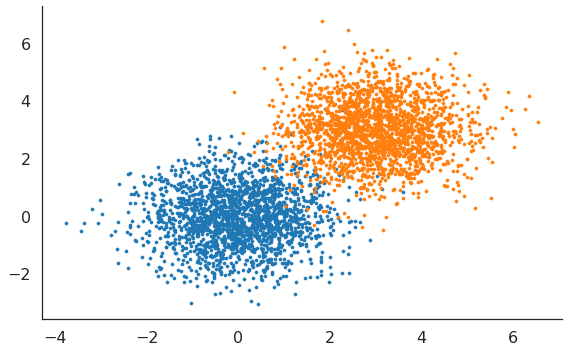

In [11]:
plt.figure(figsize=(8,5))
plt.scatter(px[:,0], px[:,1], label='px', s=10)
plt.scatter(qx[:,0], qx[:,1], label='qx', s=10)

plt.tight_layout()
sns.despine()

In [12]:
true_xs = torch.cat([px, qx])
true_xs.shape

torch.Size([4000, 2])

In [13]:
true_ratios = torch.exp((q.log_prob(true_xs).sum(-1) - p.log_prob(true_xs).sum(-1)))

In [14]:
true_log_r = torch.log(true_ratios)

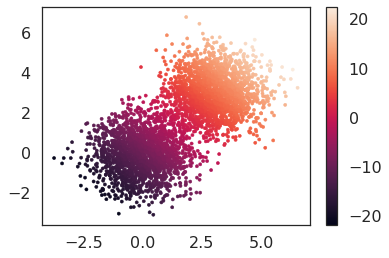

In [15]:
plt.scatter(true_xs[:,0].data.cpu().numpy(), true_xs[:,1].data.cpu().numpy(), s=10, c=true_log_r.data.cpu().numpy())
plt.colorbar()

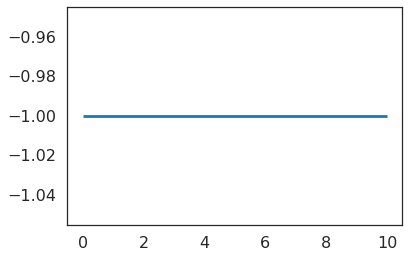

In [16]:
plt.hlines(-1,0,10)

In [17]:
np.eye(2)

array([[1., 0.],
       [0., 1.]])

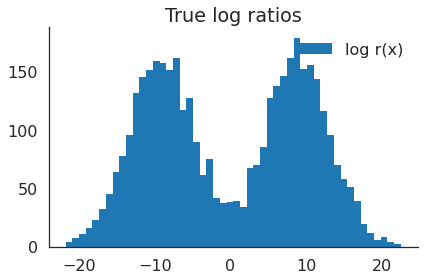

In [18]:
_ = plt.hist(true_log_r.data.cpu().numpy(), bins=50, label='log r(x)')
plt.title('True log ratios')

plt.legend()
sns.despine()
plt.tight_layout()

------

# MI

In [5]:
import torch

In [6]:
def rho_to_mi(dim, rho):
    """Obtain the ground truth mutual information from rho."""
    return -0.5 * np.log(1 - rho**2) * dim


def mi_to_rho(dim, mi):
    """Obtain the rho for Gaussian give ground truth mutual information."""
    return np.sqrt(1 - np.exp(-2.0 / dim * mi))

In [7]:
def sample_correlated_gaussian(rho=0.5, dim=2, batch_size=1000, cubic=None):
    """Generate samples from a correlated Gaussian distribution."""
    x, eps = torch.chunk(torch.randn(batch_size, 2 * dim), 2, dim=1)
    y = rho * x + torch.sqrt(torch.tensor(1. - rho**2).float()) * eps

    if cubic is not None:
        y = y ** 3

    return x, y

In [8]:
rho = 0.95

In [9]:
x,y = sample_correlated_gaussian(rho=rho, dim=1)

In [10]:
rho_to_mi(2, rho)

2.3279029009783354

In [11]:
rho_to_mi(1, rho)

1.1639514504891677

Text(0.5, 1.0, 'rho=0.95')

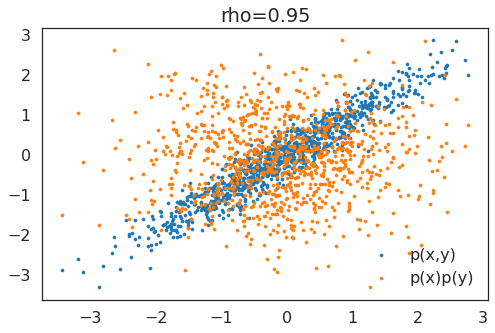

In [60]:
plt.figure(figsize=(8,5))

plt.scatter(x, y, s=10, label='p(x,y)')
plt.scatter(x, np.random.permutation(y), s=10, label='p(x)p(y)')
plt.legend()
plt.title('rho={}'.format(rho))

In [ ]:
# alternative?

In [21]:
from scipy.linalg import block_diag
from scipy.stats import multivariate_normal

In [34]:
cov = np.eye(2)
cov[0,1] = 0.9
cov[1,0] = 0.9
cov

array([[1. , 0.9],
       [0.9, 1. ]])

In [35]:
num = multivariate_normal(mean=[0,3],cov=cov).rvs(1000)
num

array([[-1.70411069,  1.18692599],
       [-1.06295088,  1.80661154],
       [ 0.4589832 ,  2.48919473],
       ...,
       [ 0.26415457,  2.14754104],
       [-0.70150774,  1.89440363],
       [ 1.1480176 ,  4.11812297]])

In [36]:
denom = multivariate_normal(mean=[0,3],cov=np.eye(2)).rvs(1000)
denom

array([[-2.36702412,  1.37810987],
       [ 0.10913786,  2.00930868],
       [-1.31549096,  3.3316336 ],
       ...,
       [-1.41860374,  4.14278169],
       [ 0.80073985,  3.35569136],
       [-0.11326497,  3.73868599]])

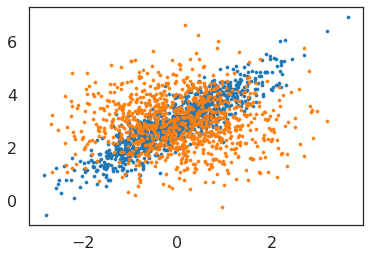

In [37]:
plt.scatter(num[:,0], num[:,1], s=10)
plt.scatter(denom[:,0], denom[:,1], s=10)

In [ ]:
def sample_gaussian(self, n_samples, cov_matrix):
    prod_of_marginals = multivariate_normal(mean=np.zeros(self.dim), cov=cov_matrix)
    return prod_of_marginals.rvs(n_samples)

def sample_data(self, n_samples):
    # p_0 (correlated distribution) -> q(x)
    return torch.from_numpy(
        self.sample_gaussian(n_samples, self.cov_matrix)).float()

def sample_denominator(self, n_samples):
    # p_m (noise distribution) -> p(x)
    return torch.from_numpy(
        self.sample_gaussian(n_samples, self.denom_cov_matrix)).float()